# FRAUD DETECTION USING UNLABELED DATA

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [3]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [4]:
#specify data path

data = Path.cwd() / 'data' 

ch3 = data / 'chapter_3'
banksim_file = ch3 / 'banksim.csv'
banksim_adj_file = ch3 / 'banksim_adj.csv'
db_full_file = ch3 / 'db_full.pickle'
labels_file = ch3 / 'labels.pickle'
labels_full_file = ch3 / 'labels_full.pickle'
x_scaled_file = ch3 / 'x_scaled.pickle'
x_scaled_full_file = ch3 / 'x_scaled_full.pickle'


### Obtain the shape of the dataframe df to inspect the size of our data and display the first rows to see which features are available.

In [5]:

banksim_df = pd.read_csv(banksim_file)
banksim_df.drop(['Unnamed: 0'], axis=1, inplace=True)
banksim_adj_df = pd.read_csv(banksim_adj_file)
banksim_adj_df.drop(['Unnamed: 0'], axis=1, inplace=True)


In [6]:
banksim_df.shape

(7200, 5)

In [7]:
banksim_df.head()

,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


In [8]:
banksim_adj_df.shape

(7189, 18)

In [9]:
banksim_adj_df.head()

,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [10]:
# Group the data by transaction category and take the mean of the data.
#banksim_df.groupby(['category']).mean()

#expected result: the majority of fraud is observed in travel, leisure and sports related transactions.

In [11]:
#Group the dataframe df by the category age and get the means for each age group.

#banksim_df.groupby(['age']).mean()

In [12]:
# Count the values of each age group.

#banksim_df.age.value_counts()

# No, the age groups who are the largest are relatively similar.

###  investigate the average amounts spent in normal transactions versus fraud transactions. This gives you an idea of how fraudulent transactions differ structurally from normal transactions.

In [13]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = banksim_df[banksim_df.fraud == 1] 
df_non_fraud = banksim_df[banksim_df.fraud == 0]

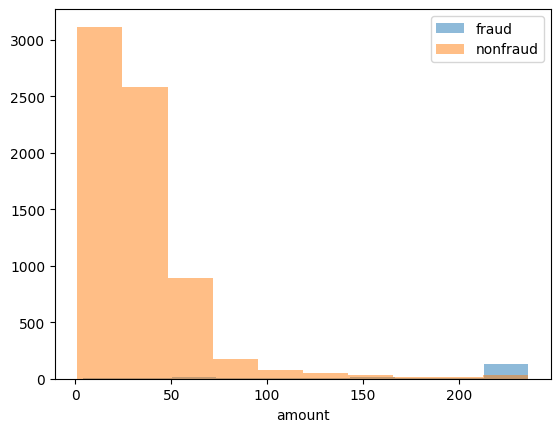

In [14]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.xlabel('amount')
plt.legend()
plt.show()

### SCALING DATA

##### For ML algorithms using distance based metrics, it is crucial to always scale your data, as features using different scales will distort your results

In [15]:
# fraud labels are separately stored under labels to check the results later.
labels = banksim_adj_df.fraud

In [16]:
# Transform your dataframe df into a numpy array X
cols = ['age', 'amount', 'M', 'es_barsandrestaurants', 'es_contents',
        'es_fashion', 'es_food', 'es_health', 'es_home', 'es_hotelservices',
        'es_hyper', 'es_leisure', 'es_otherservices', 'es_sportsandtoys',
        'es_tech', 'es_transportation', 'es_travel']

In [17]:
# Make sure the values are float
X = banksim_adj_df[cols].values.astype(float)

In [18]:
X.shape

(7189, 17)

In [19]:
# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### K-MEANS CLUSTERING

In [20]:
# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

In [21]:
# Fit the model to the scaled data
kmeans.fit(X_scaled)

MiniBatchKMeans(random_state=0)

#### ELBOW METHOD TO GET THE NUMBER OF CLUSTERS RIGHT

In [22]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

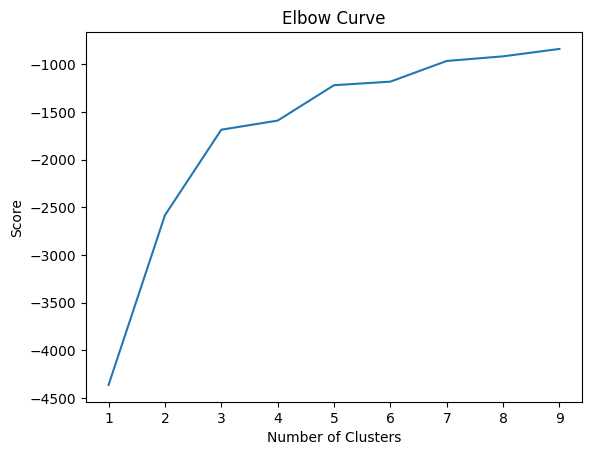

In [23]:
# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## ASSIGNING FRAUD VS NON-FRAUD

#### Detecting outliers

In [1]:
# Split the data into training and test set
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)
 
# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

NameError: name 'X_scaled' is not defined

In [25]:
km_y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
# val = pd.DataFrame(km_y_pred, labels=['dist'])

# km_y_pred = km_y_pred.replace({0:isFraud, 1:isNotFraud})

#### check results

In [27]:
# Obtain the area under the ROC curve from your test labels and predicted labels.

from itertools import product


def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [28]:
# Obtain the ROC score
from sklearn.metrics import roc_auc_score


roc_auc_score(y_test, km_y_pred)

0.8197704982668266

Confusion matrix, without normalization


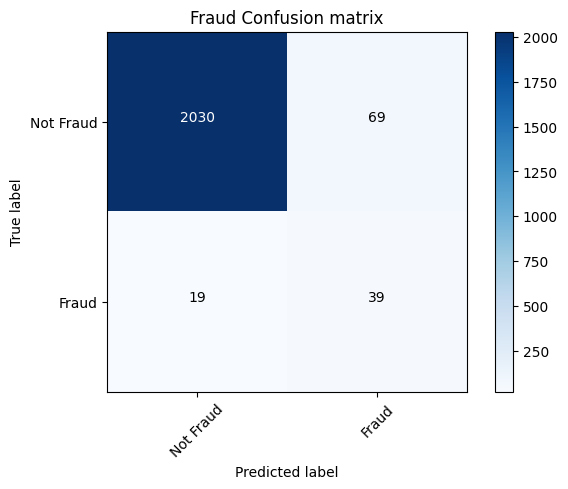

In [29]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix


km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

### Pickle model for extraction

In [30]:
import pickle

# open a file, where you ant to store the data
filename = open('pickle/fraud_detector.pkl', 'wb')

# dump information to that file
pickle.dump(kmeans,filename)
